Step 1: Definição de parâmetros iniciais:

- **population_size:** Número de portfólios na população inicial.
- **num_generations:** Quantidade de gerações a serem executadas.
- **mutation_rate:** Probabilidade de mutação nos portfólios.
- **crossover_rate:** Probabilidade de crossover entre portfólios.
- **tickers:** Seleção de alguns ativos para o teste

In [18]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Parâmetros do Algoritmo Genético
population_size = 100  # Tamanho da população
num_generations = 10   # Número de gerações
mutation_rate = 0.1    # Taxa de mutação
crossover_rate = 0.8  # Taxa de cruzamento

# Definir os tickers das ações
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL']

Step 2: Coleta de dados históricos

Neste passo, estamos baixando os dados históricos das ações selecionadas (AAPL, MSFT, TSLA, AMZN, GOOGL) para o período de 01/01/2018 a 01/01/2023, ajustados para o valor de fechamento.

yf.download(): Função utilizada para coletar os dados históricos.

In [19]:
# Baixar dados históricos (últimos 5 anos)
data = yf.download(tickers, start='2018-01-01', end='2023-01-01', auto_adjust=True)

# Exibir as primeiras linhas dos dados coletados para ver as colunas
data.head()

[*********************100%***********************]  5 of 5 completed


Price           Close                                                   High  \
Ticker           AAPL       AMZN      GOOGL       MSFT       TSLA       AAPL   
Date                                                                           
2018-01-02  40.426823  59.450500  53.340599  79.328529  21.368668  40.436212   
2018-01-03  40.419785  60.209999  54.250641  79.697723  21.150000  40.964255   
2018-01-04  40.607540  60.479500  54.461376  80.399162  20.974667  40.710802   
2018-01-05  41.069870  61.457001  55.183544  81.395973  21.105333  41.156702   
2018-01-08  40.917328  62.343498  55.378380  81.479034  22.427334  41.213030   

Price                                                   ...       Open  \
Ticker           AMZN      GOOGL       MSFT       TSLA  ...       AAPL   
Date                                                    ...              
2018-01-02  59.500000  53.478274  79.660796  21.474001  ...  39.933986   
2018-01-03  60.274502  54.478276  79.845401  21.683332  ...  40.490191   
2018-01-04  60.793499  54.874897  80.906794  21.236668  ...  40.492543   
2018-01-05  61.457001  55.347065  81.599026  21.149332  ...  40.703762   
2018-01-08  62.653999  55.624406  81.755926  22.468000  ...  40.917328   

Price                                                      Volume            \
Ticker           AMZN      GOOGL       MSFT       TSLA       AAPL      AMZN   
Date                                                                          
2018-01-02  58.599998  52.337119  79.494663  20.799999  102223600  53890000   
2018-01-03  59.415001  53.376383  79.430064  21.400000  118071600  62176000   
2018-01-04  60.250000  54.527481  79.919218  20.858000   89738400  60442000   
2018-01-05  60.875500  54.843584  80.906805  21.108000   94640000  70894000   
2018-01-08  61.799999  55.218837  81.405196  21.066668   82271200  85590000   

Price                                      
Ticker         GOOGL      MSFT       TSLA  
Date                                       
2018-01-02  31766000  22483800   65283000  
2018-01-03  31318000  26061400   67822500  
2018-01-04  26052000  21912000  149194500  
2018-01-05  30250000  23407100   68868000  
2018-01-08  24644000  22113000  147891000  

[5 rows x 25 columns]

Step 3: Cálculo de retorno e risco das ações

Neste passo, estamos calculando o retorno diário e o risco das ações, utilizando os dados de fechamento obtidos anteriormente:

**- Retorno diário:** Calculado a partir da variação percentual dos preços de fechamento de cada ação.

    Utilizamos a função pct_change() para calcular a variação percentual diária.

**- Risco (volatilidade):** Calculado como o desvio padrão dos retornos diários, que mede a dispersão dos retornos em relação à média.

    Utilizamos a função std() para calcular o desvio padrão dos retornos.

**- Retorno médio diário:** A média dos retornos diários de cada ação.

    Utilizamos a função mean() para calcular o retorno médio.

In [20]:
# Calcular o retorno diário das ações usando a coluna 'Close'
returns = data['Close'].pct_change()

# Calcular o risco (desvio padrão) dos retornos
risk = returns.std()

# Calcular o retorno médio diário de cada ação
avg_return = returns.mean()

# Exibir os valores de risco e retorno médio
print("Retorno médio diário de cada ação:\n", avg_return)
print("\nRisco (volatilidade) de cada ação:\n", risk)


Retorno médio diário de cada ação:
 Ticker
AAPL     0.001141
AMZN     0.000529
GOOGL    0.000591
MSFT     0.001055
TSLA     0.002243
dtype: float64

Risco (volatilidade) de cada ação:
 Ticker
AAPL     0.021094
AMZN     0.022554
GOOGL    0.019778
MSFT     0.019549
TSLA     0.041287
dtype: float64


Step 4: Definição da função de Fitness (Índice de Sharpe)

Neste passo, definimos a função fitness(), que será usada para calcular o Índice de Sharpe de cada portfólio. O Índice de Sharpe é uma medida de performance ajustada ao risco, que nos ajuda a avaliar a relação entre o retorno do portfólio e o risco (volatilidade).

**Entrada da função:**

- weights: Os pesos atribuídos a cada ação no portfólio.
- avg_return: O retorno médio diário de cada ação.
- risk: O risco (desvio padrão) de cada ação.

**Cálculos na função:**

- Retorno do portfólio: Calculado como o produto escalar entre os pesos e o retorno médio das ações.
- Risco do portfólio: Calculado a partir da matriz de covariância dos retornos das ações e os pesos do portfólio.
- Índice de Sharpe: Calculado como a diferença entre o retorno do portfólio e a taxa livre de risco (assumida como 0), dividida pelo risco do portfólio.

A função retorna o Índice de Sharpe, que será utilizado para avaliar a qualidade do portfólio.

In [ ]:
import numpy as np

# Definir a função de fitness (Índice de Sharpe)
def fitness(weights, avg_return, risk):
    # Calcular o retorno do portfólio
    portfolio_return = np.dot(weights, avg_return)
    
    # Calcular o risco (volatilidade) do portfólio
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    
    # Taxa livre de risco (assumimos 0 para simplificação)
    risk_free_rate = 0
    
    # Calcular o Índice de Sharpe
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
    return sharpe_ratio

Step 5: Geração de Pesos Aleatórios e Cálculo do Índice de Sharpe

Neste passo, geramos pesos aleatórios para o portfólio e calculamos o Índice de Sharpe correspondente.

- **Geração de Pesos Aleatórios:**
    
    Geramos um vetor de pesos aleatórios com o mesmo comprimento que o número de ações no portfólio (definido em tickers).
    
    Normalizamos os pesos para garantir que a soma deles seja igual a 1. Isso é necessário para que a alocação de capital no portfólio seja válida (a soma dos pesos deve ser 100%).
    
- **Cálculo do Índice de Sharpe:**

    Usamos a função fitness() definida no passo anterior para calcular o Índice de Sharpe com os pesos aleatórios.

    O Índice de Sharpe nos ajuda a medir o desempenho do portfólio em relação ao risco.

In [22]:
# Gerar pesos aleatórios que somam 1
weights = np.random.random(len(tickers))
weights /= np.sum(weights)  # Normalizar para que a soma dos pesos seja 1

# Calcular o índice de Sharpe para os pesos aleatórios
sharpe_value = fitness(weights, avg_return, risk)

# Exibir o valor do índice de Sharpe
print(f"Pesos aleatórios do portfólio: {weights}")
print(f"Índice de Sharpe do portfólio: {sharpe_value}")


Pesos aleatórios do portfólio: [0.01879513 0.46545216 0.13950169 0.1533866  0.22286442]
Índice de Sharpe do portfólio: 0.04758908910113136


Step 6: Funções de Seleção, Crossover e Mutação

Neste passo, implementamos as funções principais do Algoritmo Genético, que são responsáveis pela seleção, crossover e mutação dos portfólios.

- Seleção (Roleta):

A função selection() escolhe os portfólios para a próxima geração com base no índice de fitness (índice de Sharpe). A probabilidade de seleção é maior para os portfólios com melhor desempenho.

Usamos a seleção por roleta, onde os melhores portfólios têm maior chance de ser escolhidos.

- Crossover:

A função crossover() combina dois portfólios (pais) para gerar dois novos portfólios (filhos).

O ponto de corte é aleatório, e o crossover mistura os pesos dos pais para criar filhos.

- Mutação:

A função mutation() introduz uma mutação em um portfólio, alterando aleatoriamente um de seus pesos.

Após a mutação, a soma dos pesos é normalizada para garantir que a soma total seja 1.

In [23]:
import numpy as np

# Função de seleção (roleta)
def selection(population, fitness_values):
    total_fitness = np.sum(fitness_values)
    selection_prob = fitness_values / total_fitness  # Probabilidade de seleção
    selected_indices = np.random.choice(range(len(population)), size=len(population), p=selection_prob)
    selected_population = [population[i] for i in selected_indices]
    return selected_population

# Função de crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))  # Ponto de corte
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# Função de mutação
def mutation(portfolio):
    mutation_point = np.random.randint(0, len(portfolio))
    portfolio[mutation_point] = np.random.random()
    portfolio /= np.sum(portfolio)  # Normalizar para que a soma dos pesos seja 1
    return portfolio


Step 7: Execução do Algoritmo Genético e Visualização da Evolução

Neste passo, executamos o Algoritmo Genético para otimizar o portfólio ao longo de várias gerações. A cada geração, novos portfólios são gerados através de seleção, crossover e mutação, e o índice de Sharpe é calculado para avaliar a performance de cada portfólio.

**1. Parâmetros do Algoritmo Genético:**
population_size: Define o número de portfólios na população inicial.

num_generations: Define o número de gerações a serem executadas.

mutation_rate: Define a probabilidade de mutação em cada portfólio.

crossover_rate: Define a probabilidade de crossover entre os portfólios.

**2. População Inicial:**
A população inicial de portfólios é criada aleatoriamente com pesos que somam 1.

**3. Execução do Algoritmo:**
Cálculo de fitness (índice de Sharpe): Para cada portfólio, calculamos o índice de Sharpe, que mede a performance ajustada ao risco.

Seleção: Os portfólios são selecionados com base no índice de Sharpe.

Crossover e Mutação: Após a seleção, novos portfólios são gerados, com alguns passando por mutações para explorar novas soluções.

**4. Exibição da Evolução do Índice de Sharpe:**
O gráfico mostra como o índice de Sharpe evolui ao longo das gerações, com uma linha fixa para os limites do eixo Y, facilitando a visualização das melhorias.

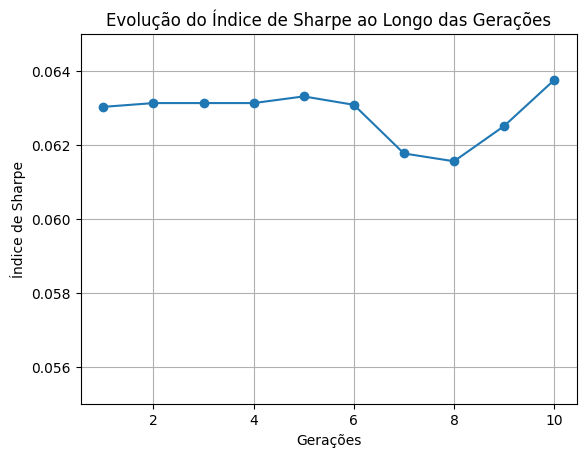

In [24]:
# Parâmetros do Algoritmo Genético
population_size = 100  # Tamanho da população
num_generations = 10   # Número de gerações
mutation_rate = 0.1    # Taxa de mutação (probabilidade de mutação de um portfólio)
crossover_rate = 0.8   # Taxa de cruzamento (probabilidade de cruzamento de dois portfólios)

# Criar uma população inicial de portfólios aleatórios
population = [np.random.random(len(tickers)) for _ in range(population_size)]
population = [individual / np.sum(individual) for individual in population]

# Rodar o algoritmo genético
sharpe_history = []  # Para armazenar o índice de Sharpe ao longo das gerações

for generation in range(num_generations):
    # Calcular o fitness (índice de Sharpe) de cada portfólio
    fitness_values = np.array([fitness(individual, avg_return, risk) for individual in population])
    
    # Seleção: Escolher os melhores portfólios
    selected_population = selection(population, fitness_values)
    
    # Crossover e mutação para gerar nova população
    new_population = []
    for i in range(0, population_size, 2):
        parent1, parent2 = selected_population[i], selected_population[i + 1]
        if np.random.rand() < crossover_rate:
            child1, child2 = crossover(parent1, parent2)
        else:
            child1, child2 = parent1, parent2
        if np.random.rand() < mutation_rate:
            child1 = mutation(child1)
        if np.random.rand() < mutation_rate:
            child2 = mutation(child2)
        new_population.extend([child1, child2])
    
    population = new_population
    best_fitness_value = np.max(fitness_values)
    sharpe_history.append(best_fitness_value)

# Exibir a evolução do índice de Sharpe
import matplotlib.pyplot as plt

# Definir limites fixos para o eixo Y
min_sharpe = 0.055  # valor mínimo para o índice de Sharpe
max_sharpe = 0.065  # valor máximo para o índice de Sharpe

plt.plot(range(1, num_generations + 1), sharpe_history, marker='o')
plt.xlabel('Gerações')
plt.ylabel('Índice de Sharpe')
plt.title('Evolução do Índice de Sharpe ao Longo das Gerações')

plt.ylim(min_sharpe, max_sharpe)
plt.grid(True)
plt.show()


Step 8: Encontrar o Melhor Portfólio da Última Geração

Após a execução do algoritmo genético por várias gerações, o melhor portfólio da última geração é selecionado com base no índice de Sharpe. Esse portfólio é aquele que apresenta a melhor alocação de ativos para maximizar o retorno ajustado ao risco.

**1. Cálculo do Melhor Portfólio:**
O portfólio com o maior índice de Sharpe é selecionado.

Para isso, utilizamos a função np.argmax para identificar o índice do maior valor de fitness (índice de Sharpe).

**2. Exibição do Melhor Portfólio:**
A alocação de capital entre os ativos selecionados é exibida, junto com o índice de Sharpe correspondente, que representa a qualidade da escolha do portfólio em termos de retorno e risco.

In [25]:
# Encontrar o melhor portfólio da última geração
best_final_index = np.argmax(fitness_values)
best_portfolio = population[best_final_index]
best_sharpe = fitness_values[best_final_index]

# Exibir o melhor portfólio da última geração
print(f"\nMelhor portfólio da última geração:")
for i, weight in enumerate(best_portfolio):
    print(f"{tickers[i]}: {weight:.4f}")

# Exibir o índice de Sharpe do melhor portfólio
print(f"\nÍndice de Sharpe do melhor portfólio: {best_sharpe:.4f}")



Melhor portfólio da última geração:
AAPL: 0.2075
MSFT: 0.1454
TSLA: 0.2386
AMZN: 0.1892
GOOGL: 0.5347

Índice de Sharpe do melhor portfólio: 0.0638
